In [2]:
import os
import sys
from collections import defaultdict, Counter
from functools import reduce, partial

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Read vertebrates mtDNA genomes downloaded from genbank

Query to NCBI nuccore db (2024-05-13):
```
(("Chordata"[Organism] OR chordates[All Fields]) AND complete[All Fields] AND genome[All Fields]) AND (refseq[filter] AND mitochondrion[filter])
```

In [76]:
path_to_vertebrates_mtdna = '../data/vertebrates_mtdna.gb'
i = 0
d = []
for rec in SeqIO.parse(path_to_vertebrates_mtdna, 'genbank'):
    i += 1
    n_ori = len([x.type for x in rec.features if x.type == 'rep_origin'])
    d.append(n_ori)
    if n_ori == 2:
        for fea in rec.features:
            if fea.type == 'rep_origin':
                print(i, rec.annotations.get('organism'))
                print(fea)

print('n_ori:', Counter(d))

32 Trachops cirrhosus
type: rep_origin
location: [5182:5214](+)
qualifiers:
    Key: note, Value: ['Replication origin Ligth Chain']

32 Trachops cirrhosus
type: rep_origin
location: [15443:15701](+)
qualifiers:
    Key: note, Value: ['Replication origin Heavy Chain']

202 Triakis semifasciata
type: rep_origin
location: [5289:5319](+)
qualifiers:
    Key: note, Value: ['origin of L-strand replication']

202 Triakis semifasciata
type: rep_origin
location: [15917:16612](+)
qualifiers:
    Key: note, Value: ['origin of H-strand replication']

2233 Pelophylax nigromaculatus
type: rep_origin
location: [936:1000](+)
qualifiers:
    Key: note, Value: ['H-strand origin of replication']

2233 Pelophylax nigromaculatus
type: rep_origin
location: [7794:7825](+)
qualifiers:
    Key: note, Value: ['L-strand origin of replication']

2260 Xenopus laevis
type: rep_origin
location: [1561:1601](+)
qualifiers:
    Key: note, Value: ['H-strand origin of replication (approx)']

2260 Xenopus laevis
type: re

### Eaxtract cytb and oriL locations from genbank files

In [5]:
path_to_vertebrates_mtdna = '../data/vertebrates_mtdna.gb'

data = []
columns = [
    'acc', 'organism', 
    'ori_start', 'ori_end', 'ori_strand', 
    'cytb_start', 'cytb_end', 'cytb_strand',
]
i = 0
for rec in SeqIO.parse(path_to_vertebrates_mtdna, 'genbank'):
    i += 1
    n_ori = len([x.type for x in rec.features if x.type == 'rep_origin'])
    if n_ori > 1:
        continue
    
    acc = rec.id
    organism = rec.annotations.get('organism')
    cytb_start = cytb_end = None
    ori_start = ori_end = None
    cytb_strand = None
    ori_strand = None
    for fea in rec.features:
        if fea.type == 'rep_origin':
            # print(i, fea)
            ori_strand = fea.strand
            ori_start, ori_end = fea.location.nofuzzy_start, fea.location.nofuzzy_end
        # elif fea.type == 'D-loop':
            # print(i, fea)
        elif fea.type == 'CDS':
            if fea.qualifiers.get('gene') and fea.qualifiers.get('gene')[0].lower() == 'cytb' or \
                fea.qualifiers.get('product') and fea.qualifiers.get('product')[0].lower() == 'cytochrome b':
                # print(i, fea.qualifiers.get('gene'))
                cytb_strand = fea.strand
                cytb_start, cytb_end = fea.location.nofuzzy_start, fea.location.nofuzzy_end
    
    data.append(
        [acc, organism, ori_start, ori_end, ori_strand, cytb_start, cytb_end, cytb_strand]
    )

    # if i > 100:
    #     break

In [7]:
df_loc = pd.DataFrame(data, columns=columns)
df_loc['ori_len'] = df_loc['ori_end'] - df_loc['ori_start']
df_loc['cytb_len'] = df_loc['cytb_end'] - df_loc['cytb_start']
df_loc['cytb_relative_loc'] = df_loc['cytb_start'] - df_loc['ori_start']
df_loc.to_csv('../data/cytb_and_oriL_location_genbank_annot.csv', index=False)

## Explore cytb and oriL locations (EDA)

In [4]:
df_loc = pd.read_csv('../data/cytb_and_oriL_location_genbank_annot.csv')
df_loc

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
0,NC_080231.1,Pama pama,NaN,NaN,NaN,14391.0,15532.0,1.0,NaN,1141.0,NaN
1,NC_065807.1,Sciurus anomalus,5184.0,5215.0,1.0,14175.0,15315.0,1.0,31.0,1140.0,8991.0
2,NC_060619.1,Pomatoschistus minutus,NaN,NaN,NaN,14351.0,15492.0,1.0,NaN,1141.0,NaN
3,NC_012825.1,Cynoglossus semilaevis,NaN,NaN,NaN,15426.0,16563.0,1.0,NaN,1137.0,NaN
4,NC_007693.1,Manouria emys,NaN,NaN,NaN,14216.0,15360.0,1.0,NaN,1144.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7827,NC_082237.1,Mesechinus dauuricus,NaN,NaN,NaN,14205.0,15345.0,1.0,NaN,1140.0,NaN
7828,NC_060375.1,Myanophis thanlyinensis,6111.0,6147.0,1.0,15001.0,16118.0,1.0,36.0,1117.0,8890.0
7829,NC_027169.1,Sinocyclocheilus anshuiensis,NaN,NaN,NaN,15334.0,16475.0,1.0,NaN,1141.0,NaN
7830,NC_027168.1,Sinocyclocheilus rhinocerous,NaN,NaN,NaN,15305.0,16446.0,1.0,NaN,1141.0,NaN


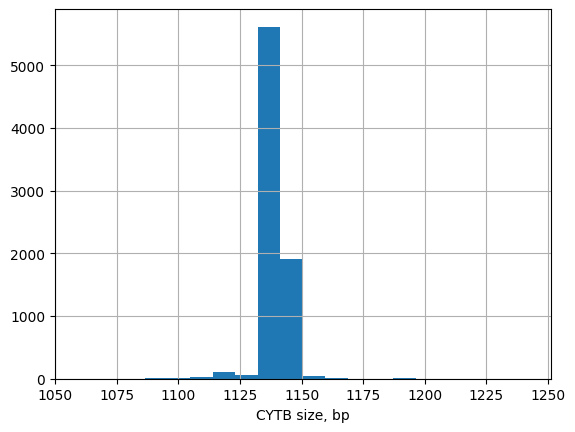

In [9]:
df_loc.cytb_len.hist(bins=20).set_xlabel('CYTB size, bp');

In [10]:
df_loc.cytb_strand.value_counts()

 1.0    7807
-1.0      21
Name: cytb_strand, dtype: int64

In [11]:
df_loc['ori_len'].describe()

count    2203.000000
mean       44.972764
std       161.106286
min        11.000000
25%        31.000000
50%        34.000000
75%        36.000000
max      3423.000000
Name: ori_len, dtype: float64

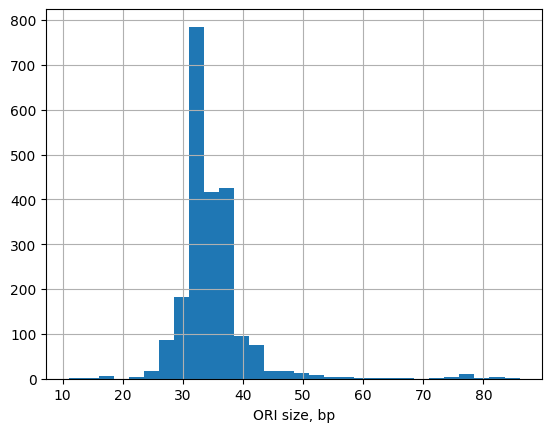

In [12]:
df_loc.ori_len[df_loc.ori_len < 100].hist(bins=30).set_xlabel('ORI size, bp');

In [5]:
df_loc_with_ori = df_loc[
    (~df_loc.ori_start.isna()) & 
    (df_loc.cytb_strand == 1) &
    (df_loc.ori_len < 100)
]
df_loc_with_ori

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
1,NC_065807.1,Sciurus anomalus,5184.0,5215.0,1.0,14175.0,15315.0,1.0,31.0,1140.0,8991.0
9,NC_063962.1,Trimerodytes annularis,6392.0,6430.0,1.0,15290.0,16407.0,1.0,38.0,1117.0,8898.0
12,NC_057198.1,Hylarana latouchii,5362.0,5388.0,-1.0,14224.0,15364.0,1.0,26.0,1140.0,8862.0
14,NC_056269.1,Quasipaa exilispinosa,5430.0,5456.0,1.0,14341.0,15487.0,1.0,26.0,1146.0,8911.0
19,NC_008450.1,Neofelis nebulosa,6077.0,6109.0,1.0,15065.0,16205.0,1.0,32.0,1140.0,8988.0
...,...,...,...,...,...,...,...,...,...,...,...
7815,NC_000893.1,Amblyraja radiata,5304.0,5341.0,-1.0,14364.0,15507.0,1.0,37.0,1143.0,9060.0
7816,NC_083923.1,Rhogeessa genowaysi,5158.0,5193.0,-1.0,14159.0,15299.0,1.0,35.0,1140.0,9001.0
7817,NC_083922.1,Rhogeessa mira,5158.0,5193.0,-1.0,14159.0,15299.0,1.0,35.0,1140.0,9001.0
7823,NC_060316.1,Micromys erythrotis,5153.0,5185.0,-1.0,14114.0,15258.0,1.0,32.0,1144.0,8961.0


In [14]:
df_loc_with_ori.ori_strand.value_counts()

 1.0    1556
-1.0     623
Name: ori_strand, dtype: int64

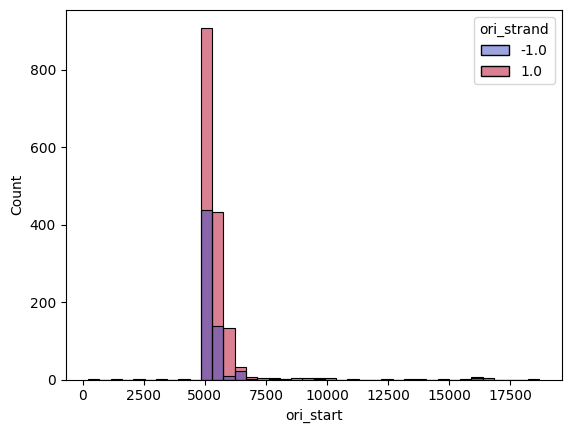

In [15]:
sns.histplot(data=df_loc_with_ori, x='ori_start', hue='ori_strand', bins=40, palette='coolwarm');

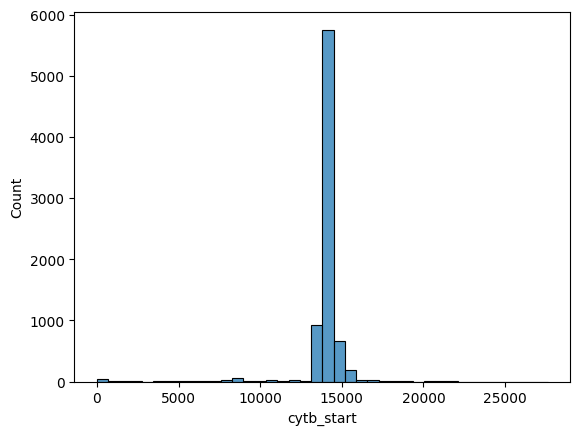

In [16]:
sns.histplot(data=df_loc, x='cytb_start', bins=40, palette='coolwarm');

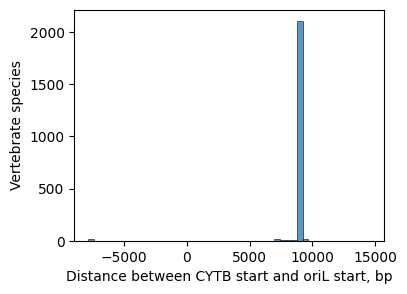

In [17]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(data=df_loc_with_ori, x='cytb_relative_loc', bins=50, palette='coolwarm')
ax.set_xlabel('Distance between CYTB start and oriL start, bp')
ax.set_ylabel('Vertebrate species');

In [18]:
df_loc_with_ori.cytb_relative_loc.describe()

count     2179.000000
mean      8881.270307
std       1376.819691
min      -7834.000000
25%       8987.000000
50%       9001.000000
75%       9065.000000
max      14605.000000
Name: cytb_relative_loc, dtype: float64

In [19]:
df_loc_with_ori.cytb_relative_loc.quantile([0.025, 0.5, 0.975])

0.025    8843.60
0.500    9001.00
0.975    9110.55
Name: cytb_relative_loc, dtype: float64

In [20]:
9110 - 9001, 9001 - 8843

(109, 158)

## Intersect with spectra dataset species

In [99]:
spectra = pd.read_csv('../data/MutSpecVertebratescytb.csv')
spectra

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii
...,...,...,...,...,...,...,...,...,...,...
185659,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves
185660,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves
185661,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves
185662,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves


In [106]:
species = spectra.Species.str.replace('_', ' ').unique()
len(species), species[:4]

(967,
 array(['Abbottina obtusirostris', 'Abbottina rivularis', 'Abramis brama',
        'Acanthogobius hasta'], dtype=object))

In [107]:
df_loc[df_loc.organism.isin(species)]

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
29,NC_017838.1,Oncorhynchus keta,5293.0,5327.0,1.0,14373.0,15514.0,1.0,34.0,1141.0,9080.0
50,NC_028088.1,Cyprinodon variegatus,5296.0,5332.0,1.0,14385.0,15525.0,1.0,36.0,1140.0,9089.0
51,NC_028087.1,Pimephales promelas,5324.0,5340.0,1.0,14377.0,15518.0,1.0,16.0,1141.0,9053.0
52,NC_025303.1,Ptychobarbus kaznakovi,NaN,NaN,NaN,15473.0,16614.0,1.0,NaN,1141.0,NaN
56,NC_018033.1,Ithaginis cruentus,NaN,NaN,NaN,14799.0,15942.0,1.0,NaN,1143.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7794,NC_002646.1,Coregonus lavaretus,NaN,NaN,NaN,14379.0,15520.0,1.0,NaN,1141.0,NaN
7801,NC_000884.1,Cavia porcellus,5144.0,5181.0,1.0,14163.0,15303.0,1.0,37.0,1140.0,9019.0
7803,NC_000861.1,Salvelinus alpinus,6295.0,6331.0,1.0,15377.0,16518.0,1.0,36.0,1141.0,9082.0
7807,NC_001992.1,Papio hamadryas,5158.0,5192.0,1.0,14171.0,15312.0,1.0,34.0,1141.0,9013.0


In [24]:
df_loc_with_ori[df_loc_with_ori.organism.isin(species)]

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc
29,NC_017838.1,Oncorhynchus keta,5293.0,5327.0,1.0,14373.0,15514.0,1.0,34.0,1141.0,9080.0
50,NC_028088.1,Cyprinodon variegatus,5296.0,5332.0,1.0,14385.0,15525.0,1.0,36.0,1140.0,9089.0
51,NC_028087.1,Pimephales promelas,5324.0,5340.0,1.0,14377.0,15518.0,1.0,16.0,1141.0,9053.0
100,NC_032692.1,Triplophysa stenura,5297.0,5327.0,1.0,14371.0,15512.0,1.0,30.0,1141.0,9074.0
104,NC_029477.1,Myodes rufocanus,5139.0,5173.0,1.0,14122.0,15265.0,1.0,34.0,1143.0,8983.0
...,...,...,...,...,...,...,...,...,...,...,...
7790,NC_002765.1,Nycticebus coucang,5199.0,5232.0,-1.0,14201.0,15341.0,1.0,33.0,1140.0,9002.0
7801,NC_000884.1,Cavia porcellus,5144.0,5181.0,1.0,14163.0,15303.0,1.0,37.0,1140.0,9019.0
7803,NC_000861.1,Salvelinus alpinus,6295.0,6331.0,1.0,15377.0,16518.0,1.0,36.0,1141.0,9082.0
7807,NC_001992.1,Papio hamadryas,5158.0,5192.0,1.0,14171.0,15312.0,1.0,34.0,1141.0,9013.0


Only 389 genomes from spectra dataset have oriL labels

## Annotate genomes manually

Prepare fasta genomes

In [27]:
# all genomes
acc_to_annotate = set(df_loc['acc'].unique())
len(acc_to_annotate)

7832

In [37]:
path_to_vertebrates_mtdna = '../data/vertebrates_mtdna.gb'
for rec in SeqIO.parse(path_to_vertebrates_mtdna, 'genbank'):
    if rec.id in acc_to_annotate:
        organism = rec.annotations.get('organism').replace(' ', '_')
        if not organism:
            continue
        try:
            SeqIO.write(rec, f'../data/genomes_to_annotate/{organism}.fasta', 'fasta')
        except:
            pass

## QC of mitos oriL labels

In [46]:
names = ['acc', 'start', 'end', 'strand', 'e-value', 'score',  'structure2d']
oril_labels = pd.read_csv('../data/mitos_oriL_labels.txt', sep='\t', header=None, 
                          usecols=[0, 4, 5, 6, 7, 8, 13], names=names)
oril_labels['acc'] = oril_labels['acc'].apply(lambda x: x[:-1] + '.' + x[-1])
oril_labels['len'] = oril_labels.end - oril_labels.start
oril_labels

,acc,start,end,strand,e-value,score,structure2d,len
0,NC_011943.1,5311,5344,1,2.800000e-08,35.7,(((((((((................))))))))),33
1,NC_048988.1,5318,5347,1,5.100000e-07,31.3,(((((((((............))))))))),29
2,NC_026900.1,5317,5346,1,1.200000e-06,30.0,(((((((((............))))))))),29
3,NC_023781.1,5313,5342,1,5.100000e-07,31.3,(((((((((............))))))))),29
4,NC_011180.1,5354,5386,1,7.400000e-07,30.7,(((((((((...............))))))))),32
...,...,...,...,...,...,...,...,...
6361,NC_071217.1,5299,5332,1,1.200000e-07,33.6,(((((((((................))))))))),33
6362,NC_088490.1,5303,5336,-1,7.300000e-07,30.8,(((((((((................))))))))),33
6363,NC_026867.1,5122,5149,1,7.600000e-07,30.7,(((((((((..........))))))))),27
6364,NC_003167.1,5222,5256,1,6.700000e-05,23.8,(((((((((.................))))))))),34


In [47]:
oril_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc          6366 non-null   object 
 1   start        6366 non-null   int64  
 2   end          6366 non-null   int64  
 3   strand       6366 non-null   int64  
 4   e-value      6366 non-null   float64
 5   score        6366 non-null   float64
 6   structure2d  6366 non-null   object 
 7   len          6366 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 398.0+ KB


In [55]:
oril_labels.strand.value_counts()

 1    5451
-1     734
Name: strand, dtype: int64

In [48]:
# drop genomes with duplicated oriL
genomes_with_dups = oril_labels.acc.value_counts()
genomes_with_dups = genomes_with_dups[genomes_with_dups > 1].index.values
oril_labels = oril_labels[~oril_labels.acc.isin(genomes_with_dups)]
genomes_with_dups.shape, oril_labels.shape

((88,), (6185, 8))

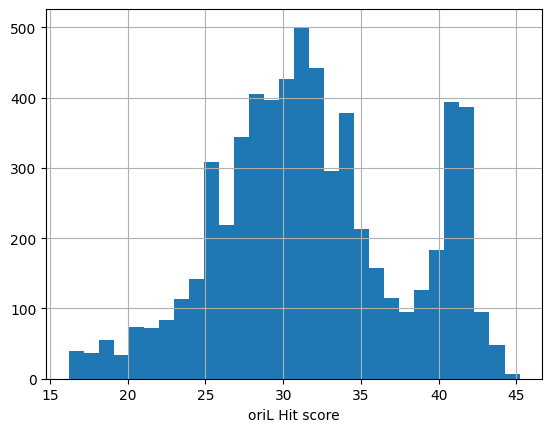

In [52]:
oril_labels.score.hist(bins=30).set_xlabel('oriL Hit score');

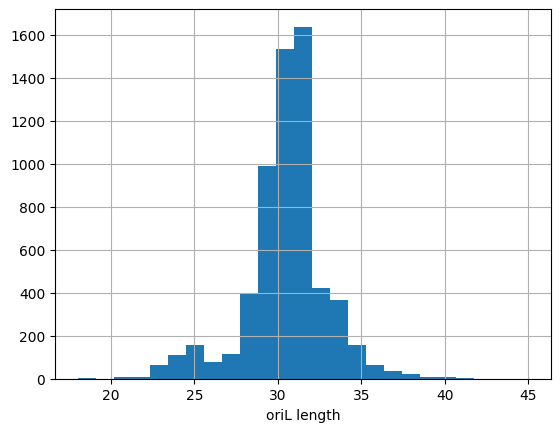

In [54]:
oril_labels['len'].hist(bins=25).set_xlabel('oriL length');

### Compare mitos oriL predictions with genbank labels

In [89]:
_ = oril_labels[['acc', 'start', 'end', 'len', 'strand']].rename(
    columns={'start': 'ori_start_mitos', 'end': 'ori_end_mitos', 'len': 'ori_len_mitos', 'strand': 'ori_strand_mitos'})

df_loc_with_mitos = df_loc.merge(_, 'left', 'acc')
df_loc_with_mitos['cytb_relative_loc_mitos'] = df_loc_with_mitos.cytb_start - df_loc_with_mitos.ori_start_mitos
df_loc_with_mitos

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc,ori_start_mitos,ori_end_mitos,ori_len_mitos,ori_strand_mitos,cytb_relative_loc_mitos
0,NC_080231.1,Pama pama,NaN,NaN,NaN,14391.0,15532.0,1.0,NaN,1141.0,NaN,5321.0,5353.0,32.0,1.0,9070.0
1,NC_065807.1,Sciurus anomalus,5184.0,5215.0,1.0,14175.0,15315.0,1.0,31.0,1140.0,8991.0,5184.0,5214.0,30.0,1.0,8991.0
2,NC_060619.1,Pomatoschistus minutus,NaN,NaN,NaN,14351.0,15492.0,1.0,NaN,1141.0,NaN,5285.0,5316.0,31.0,1.0,9066.0
3,NC_012825.1,Cynoglossus semilaevis,NaN,NaN,NaN,15426.0,16563.0,1.0,NaN,1137.0,NaN,6360.0,6387.0,27.0,1.0,9066.0
4,NC_007693.1,Manouria emys,NaN,NaN,NaN,14216.0,15360.0,1.0,NaN,1144.0,NaN,5237.0,5262.0,25.0,-1.0,8979.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7827,NC_082237.1,Mesechinus dauuricus,NaN,NaN,NaN,14205.0,15345.0,1.0,NaN,1140.0,NaN,5204.0,5238.0,34.0,1.0,9001.0
7828,NC_060375.1,Myanophis thanlyinensis,6111.0,6147.0,1.0,15001.0,16118.0,1.0,36.0,1117.0,8890.0,6111.0,6146.0,35.0,1.0,8890.0
7829,NC_027169.1,Sinocyclocheilus anshuiensis,NaN,NaN,NaN,15334.0,16475.0,1.0,NaN,1141.0,NaN,6267.0,6297.0,30.0,1.0,9067.0
7830,NC_027168.1,Sinocyclocheilus rhinocerous,NaN,NaN,NaN,15305.0,16446.0,1.0,NaN,1141.0,NaN,6238.0,6268.0,30.0,1.0,9067.0


In [105]:
species

NameError: name 'species' is not defined

In [104]:
df_loc_with_mitos.

Lateolabrax maculatus             2
Chroicocephalus brunnicephalus    2
Sardinella fijiensis              2
Rattus norvegicus                 2
Zeus faber                        2
                                 ..
Ptychadena robeensis              1
Fowleria isostigma                1
Coccorella atlantica              1
Trachurus symmetricus             1
Xenoturbella bocki                1
Name: organism, Length: 7826, dtype: int64

In [111]:
len(species)

967

In [118]:
df_loc_with_mitos[
    (df_loc_with_mitos.organism.isin(species)) & 
    (~df_loc_with_mitos.cytb_start.isna()) &
    (~df_loc_with_mitos.cytb_relative_loc_mitos.isna())].organism.values

,acc,organism,ori_start,ori_end,ori_strand,cytb_start,cytb_end,cytb_strand,ori_len,cytb_len,cytb_relative_loc,ori_start_mitos,ori_end_mitos,ori_len_mitos,ori_strand_mitos,cytb_relative_loc_mitos
29,NC_017838.1,Oncorhynchus keta,5293.0,5327.0,1.0,14373.0,15514.0,1.0,34.0,1141.0,9080.0,5296.0,5326.0,30.0,1.0,9077.0
50,NC_028088.1,Cyprinodon variegatus,5296.0,5332.0,1.0,14385.0,15525.0,1.0,36.0,1140.0,9089.0,5299.0,5331.0,32.0,1.0,9086.0
51,NC_028087.1,Pimephales promelas,5324.0,5340.0,1.0,14377.0,15518.0,1.0,16.0,1141.0,9053.0,5309.0,5339.0,30.0,1.0,9068.0
52,NC_025303.1,Ptychobarbus kaznakovi,NaN,NaN,NaN,15473.0,16614.0,1.0,NaN,1141.0,NaN,6411.0,6442.0,31.0,-1.0,9062.0
100,NC_032692.1,Triplophysa stenura,5297.0,5327.0,1.0,14371.0,15512.0,1.0,30.0,1141.0,9074.0,5298.0,5328.0,30.0,1.0,9073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7790,NC_002765.1,Nycticebus coucang,5199.0,5232.0,-1.0,14201.0,15341.0,1.0,33.0,1140.0,9002.0,5201.0,5232.0,31.0,1.0,9000.0
7794,NC_002646.1,Coregonus lavaretus,NaN,NaN,NaN,14379.0,15520.0,1.0,NaN,1141.0,NaN,5301.0,5331.0,30.0,1.0,9078.0
7801,NC_000884.1,Cavia porcellus,5144.0,5181.0,1.0,14163.0,15303.0,1.0,37.0,1140.0,9019.0,5146.0,5181.0,35.0,1.0,9017.0
7803,NC_000861.1,Salvelinus alpinus,6295.0,6331.0,1.0,15377.0,16518.0,1.0,36.0,1141.0,9082.0,6298.0,6330.0,32.0,1.0,9079.0


In [132]:
# Intersect with spectra dataset species
species_all = df_loc_with_mitos[
    (df_loc_with_mitos.organism.isin(species)) & 
    (~df_loc_with_mitos.cytb_start.isna()) &
    (~df_loc_with_mitos.cytb_relative_loc_mitos.isna())
].organism.values

print(f'{len(species_all)} species out of {len(species)} have oriL and cytb start labels')

_ = df_loc_with_mitos[(df_loc_with_mitos.organism.isin(species))].organism.values
print(f'\n{len(_)-len(species_all)} species out of {len(species)} have missing oriL or cytb start label and cannot be used for analysis')

868 species out of 967 have oriL and cytb start labels

95 species out of 967 have missing oriL or cytb start label and cannot be used for analysis


## Derive relative distance distribution based on mitos oriL location preditions

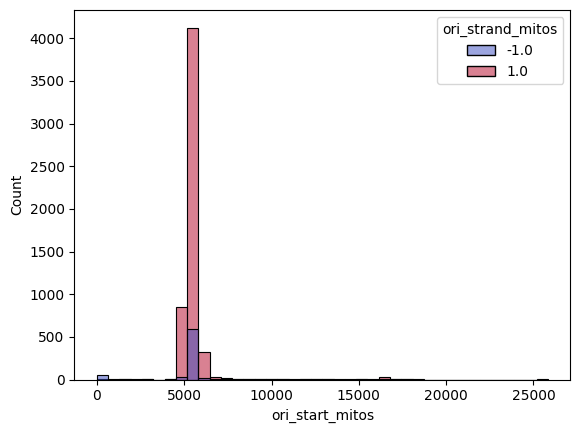

In [86]:
sns.histplot(data=df_loc_with_mitos, x='ori_start_mitos', hue='ori_strand_mitos', bins=40, palette='coolwarm');

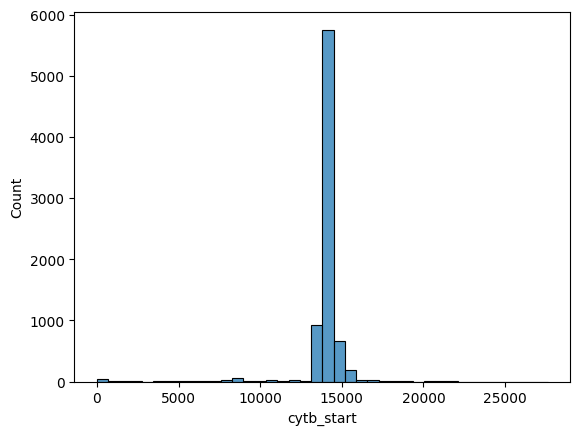

In [88]:
sns.histplot(data=df_loc_with_mitos, x='cytb_start', bins=40, palette='coolwarm');

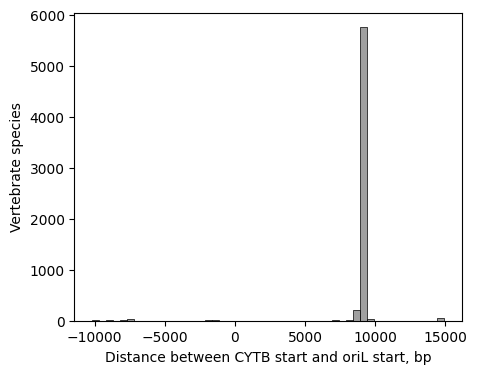

In [134]:
plt.figure(figsize=(5, 4))
ax = sns.histplot(data=df_loc_with_mitos, x='cytb_relative_loc_mitos', bins=50, color='gray')
ax.set_xlabel('Distance between CYTB start and oriL start, bp')
ax.set_ylabel('Vertebrate species')
plt.savefig('../pictures/distance_between_oriL_start_and_Cytb_start.pdf', bbox_inches='tight')
plt.show()

In [100]:
df_loc_with_mitos.cytb_relative_loc_mitos.quantile([0.025, 0.25, 0.5, 0.75, 0.975])

0.025    8586.000
0.250    8994.000
0.500    9063.000
0.750    9075.000
0.975    9202.475
Name: cytb_relative_loc_mitos, dtype: float64

**Results:**

- Median distance between Cytb start and oriL start is **9063**
- There are some outliers probably due to incorrect labeling (assume that this is noise)
- 868 out of 967 species from spectra dataset belong to this analysis. Other ~100 species have no labels due to authomatic genome annotation